# Loading Data

In [1]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
100% 1.21G/1.21G [00:47<00:00, 27.8MB/s]
100% 1.21G/1.21G [00:47<00:00, 27.2MB/s]


In [2]:
!unzip /content/gtzan-dataset-music-genre-classification.zip

Archive:  /content/gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues

In [3]:
import pandas as pd
df=pd.read_csv("/content/Data/features_30_sec.csv")

In [4]:
import pandas as pd

# Assuming your DataFrame is named df
df = df[['filename', 'label']]
df['filename']="/content/Data/genres_original/"+df['label']+"/"+df['filename']

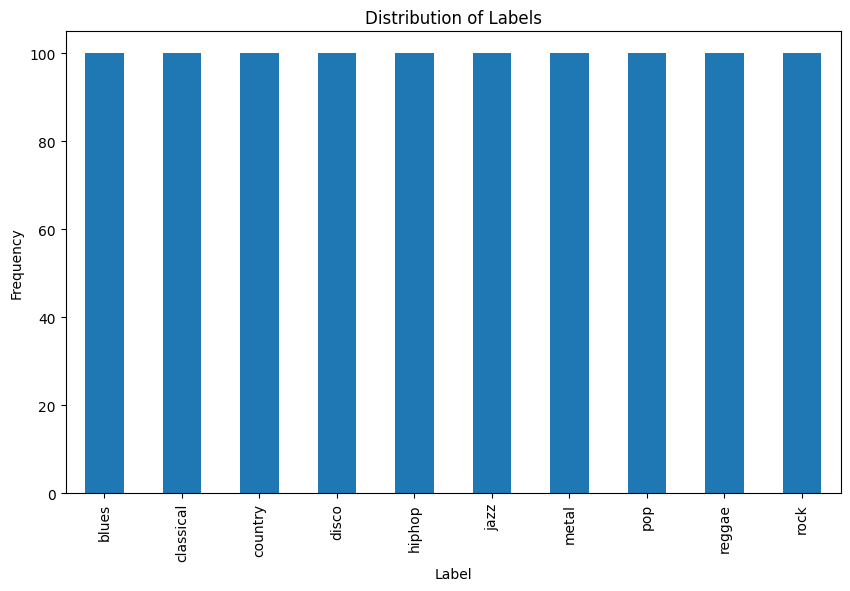

In [11]:
import matplotlib.pyplot as plt
# Create histogram for 'label' column
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

## Feautre Extraction

In [32]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize


# Function to extract and save spectrogram
def extract_and_resize_spectrogram(file_path, fixed_shape=(128, 128)):
    y, sr = librosa.load(file_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Resize spectrogram to the fixed shape
    S_dB_resized = resize(S_dB, fixed_shape, mode='constant')

    return S_dB_resized


# Loop through the DataFrame and extract spectrograms
X=[]
Y=[]
for index, row in df.iterrows():
    file_path = row['filename']
    label = row['label']
    try:
      mel_spec=extract_and_resize_spectrogram(file_path)
      X.append(mel_spec)
      Y.append(label)
    except:
      print(f"{file_path} had problem")

<ipython-input-32-dfd2f157d4ba>:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


/content/Data/genres_original/jazz/jazz.00054.wav had problem


In [33]:
# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)
X = np.expand_dims(X, axis=-1)  # Add a channel dimension

In [ ]:
import numpy as np

def train_test_split1(X, y, test_size=0.25, random_state=None):

    # Convert inputs to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Ensure consistent random state
    if random_state is not None:
        np.random.seed(random_state)

    # Shuffle the indices
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    # Determine the size of the test set
    if isinstance(test_size, float):
        test_size = int(test_size * X.shape[0])
    elif isinstance(test_size, int):
        test_size = test_size
    else:
        raise ValueError("test_size should be a float or an int")

    # Split the indices for training and testing
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    # Split the data
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test



In [34]:

from sklearn.model_selection import train_test_split


# Split data into training and testing sets with an 80-20 split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 799
Testing set size: 200


In [29]:
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)



In [35]:
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Encode the genre labels as integers
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)
Y_test = label_encoder.transform(Y_test)


In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense


model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1], X.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())


model.add(Flatten())


model.add(Dense(10, activation='softmax'))


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 63, 63, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                      

In [37]:
history = model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
20/20 [==============================] - 15s 714ms/step - loss: 2.0584 - accuracy: 0.3318 - val_loss: 21.8904 - val_accuracy: 0.0938
Epoch 2/30
20/20 [==============================] - 13s 657ms/step - loss: 1.0907 - accuracy: 0.5994 - val_loss: 14.2000 - val_accuracy: 0.1000
Epoch 3/30
20/20 [==============================] - 13s 678ms/step - loss: 0.7050 - accuracy: 0.7637 - val_loss: 8.1126 - val_accuracy: 0.2188
Epoch 4/30
20/20 [==============================] - 14s 695ms/step - loss: 0.4649 - accuracy: 0.8826 - val_loss: 5.9023 - val_accuracy: 0.2125
Epoch 5/30
20/20 [==============================] - 13s 640ms/step - loss: 0.3197 - accuracy: 0.9468 - val_loss: 4.1493 - val_accuracy: 0.2875
Epoch 6/30
20/20 [==============================] - 15s 719ms/step - loss: 0.2470 - accuracy: 0.9593 - val_loss: 2.8000 - val_accuracy: 0.3250
Epoch 7/30
20/20 [==============================] - 13s 636ms/step - loss: 0.1877 - accuracy: 0.9797 - val_loss: 2.1414 - val_accuracy: 0.40

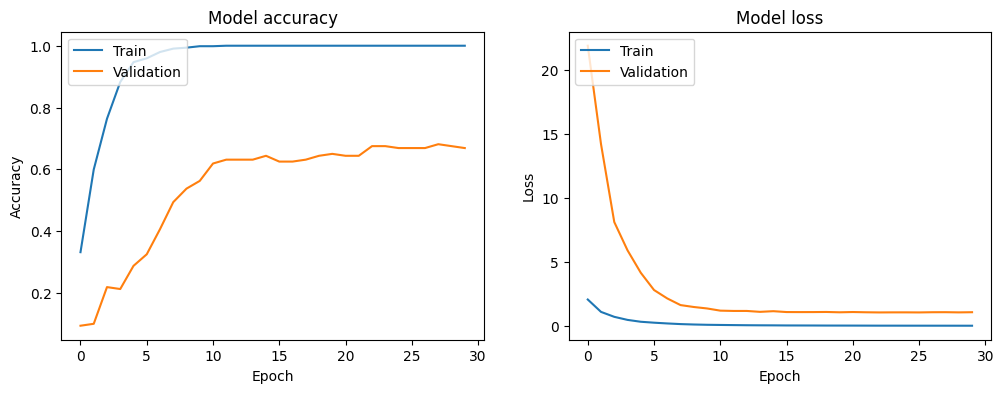

Test accuracy: 0.6950


In [38]:
import matplotlib.pyplot as plt



# Plot the loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')


7/7 [==============================] - 1s 106ms/step


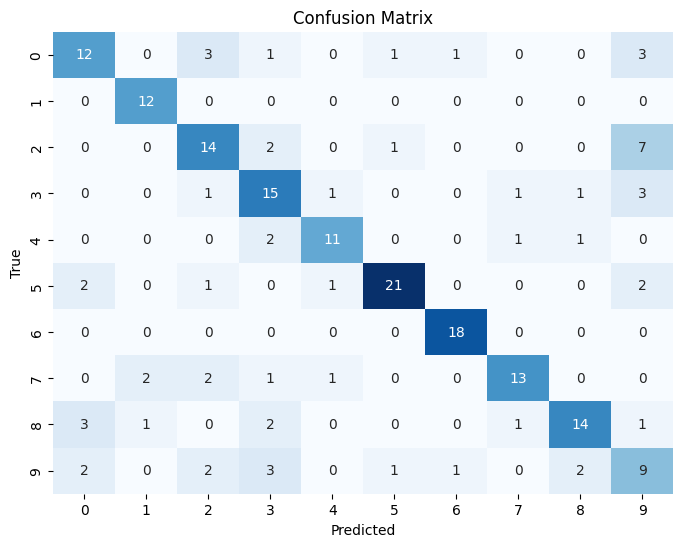

In [39]:
# Predict the test set
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)


# Compute the confusion matrix
cm = confusion_matrix(Y_test, np.argmax(Y_pred,axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [41]:
from sklearn.metrics import classification_report


# Generate classification report
report = classification_report(Y_test, np.argmax(Y_pred, axis=1))

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.57      0.60        21
           1       0.80      1.00      0.89        12
           2       0.61      0.58      0.60        24
           3       0.58      0.68      0.62        22
           4       0.79      0.73      0.76        15
           5       0.88      0.78      0.82        27
           6       0.90      1.00      0.95        18
           7       0.81      0.68      0.74        19
           8       0.78      0.64      0.70        22
           9       0.36      0.45      0.40        20

    accuracy                           0.69       200
   macro avg       0.71      0.71      0.71       200
weighted avg       0.71      0.69      0.70       200

